# Diffusion Models from Scratch

## Setup and Imports

In [1]:
%pip install -q diffusers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


device(type='cuda')

In [3]:
dataset = torchvision.datasets.MNIST(root='mnist/', train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 154807462.07it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39419360.18it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28875770.43it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8072257.95it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [4]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input Shape:  torch.Size([8, 1, 28, 28])
Labels:  tensor([1, 0, 0, 5, 4, 2, 6, 6])


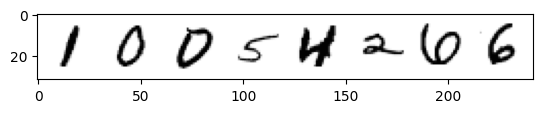

In [5]:
x, y = next(iter(train_dataloader))
print('Input Shape: ', x.shape)
print('Labels: ', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

## The Corruption Process

In [6]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + noise * amount

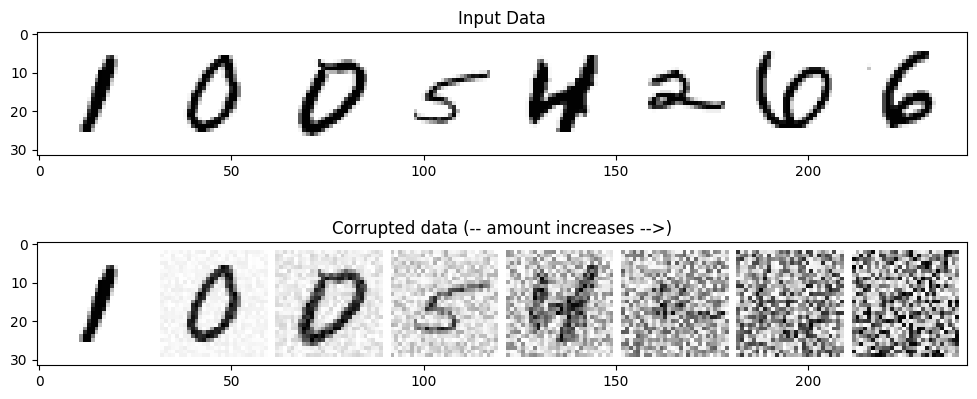

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input Data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

## The Model

In [8]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2)
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
        
    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)
        for i, l in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x += h.pop()
            x = self.act(l(x))
        
        return x

In [9]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [10]:
sum([p.numel() for p in net.parameters()])

309057

## Training the Network

Finished epoch 0. Average loss for this epoch: 0.026231
Finished epoch 1. Average loss for this epoch: 0.020189
Finished epoch 2. Average loss for this epoch: 0.018453
Finished epoch 3. Average loss for this epoch: 0.017523
Finished epoch 4. Average loss for this epoch: 0.016909
Finished epoch 5. Average loss for this epoch: 0.016815
Finished epoch 6. Average loss for this epoch: 0.016362
Finished epoch 7. Average loss for this epoch: 0.016220
Finished epoch 8. Average loss for this epoch: 0.015862
Finished epoch 9. Average loss for this epoch: 0.015668
Finished epoch 10. Average loss for this epoch: 0.015194
Finished epoch 11. Average loss for this epoch: 0.014631
Finished epoch 12. Average loss for this epoch: 0.014379
Finished epoch 13. Average loss for this epoch: 0.014048
Finished epoch 14. Average loss for this epoch: 0.013993
Finished epoch 15. Average loss for this epoch: 0.013610
Finished epoch 16. Average loss for this epoch: 0.013478
Finished epoch 17. Average loss for this 

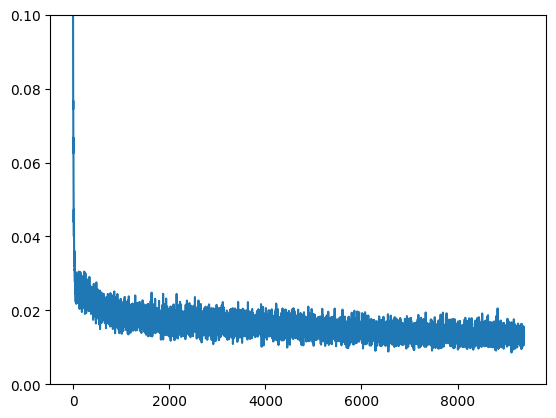

In [11]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_epochs = 20

net = BasicUNet()
net.to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3)
losses = []

for epoch in range(n_epochs):
    for x, y in train_dataloader:
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)
        
        pred = net(noisy_x)
        
        loss = loss_fn(pred, x)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

plt.plot(losses)
plt.ylim(0, 0.1);

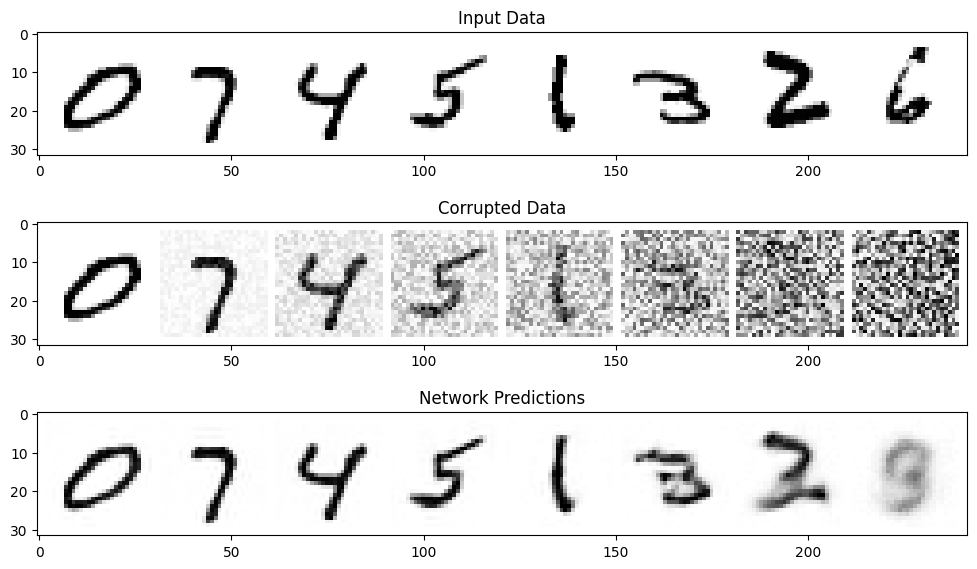

In [12]:
x, y = next(iter(train_dataloader))
x = x[:8]

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()
    
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input Data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted Data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

## Sampling

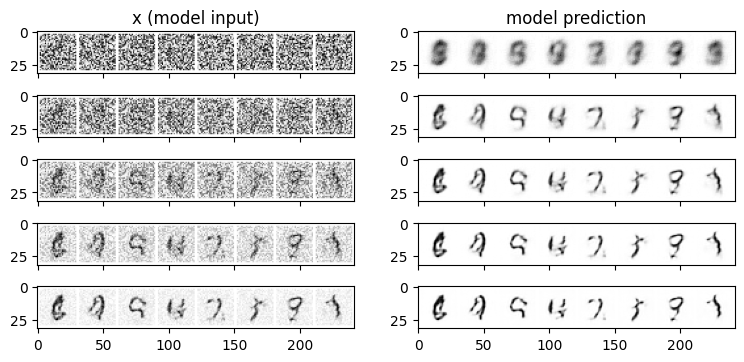

In [13]:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)
    pred_output_history.append(pred.detach().cpu())
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
    step_history.append(x.detach().cpu())
    
fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title('x (model input)')
axs[0, 1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

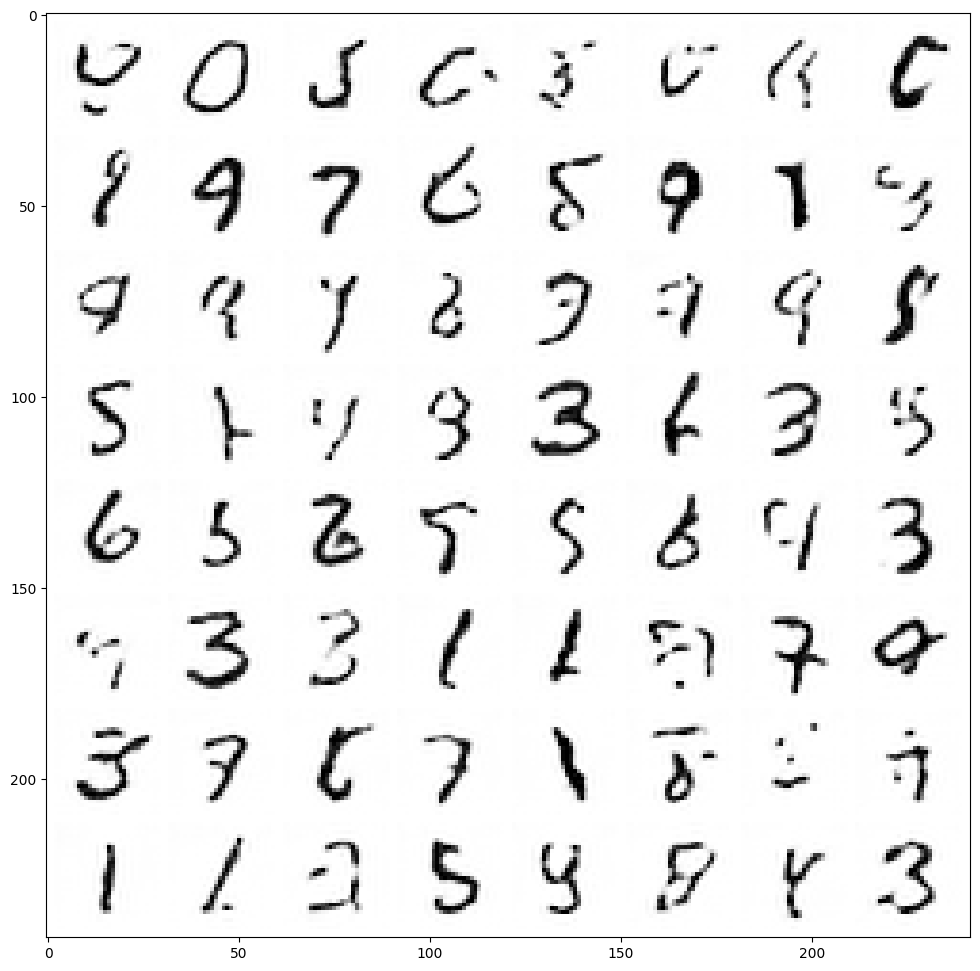

In [14]:
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i/n_steps))
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrows=8)[0].clip(0, 1), cmap='Greys');

## Comparison to DDPM

In [15]:
model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 64),
    down_block_types=('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'),
    up_block_types=('AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D')
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D

In [16]:
sum([p.numel() for p in model.parameters()])

1707009

Finished Epoch 0. Average Loss for this epoch: 0.019491
Finished Epoch 1. Average Loss for this epoch: 0.012846
Finished Epoch 2. Average Loss for this epoch: 0.011576
Finished Epoch 3. Average Loss for this epoch: 0.011120
Finished Epoch 4. Average Loss for this epoch: 0.010652
Finished Epoch 5. Average Loss for this epoch: 0.010465
Finished Epoch 6. Average Loss for this epoch: 0.010386
Finished Epoch 7. Average Loss for this epoch: 0.010031
Finished Epoch 8. Average Loss for this epoch: 0.009901
Finished Epoch 9. Average Loss for this epoch: 0.009825
Finished Epoch 10. Average Loss for this epoch: 0.009735
Finished Epoch 11. Average Loss for this epoch: 0.009738
Finished Epoch 12. Average Loss for this epoch: 0.009624
Finished Epoch 13. Average Loss for this epoch: 0.009544
Finished Epoch 14. Average Loss for this epoch: 0.009438
Finished Epoch 15. Average Loss for this epoch: 0.009416
Finished Epoch 16. Average Loss for this epoch: 0.009297
Finished Epoch 17. Average Loss for this 

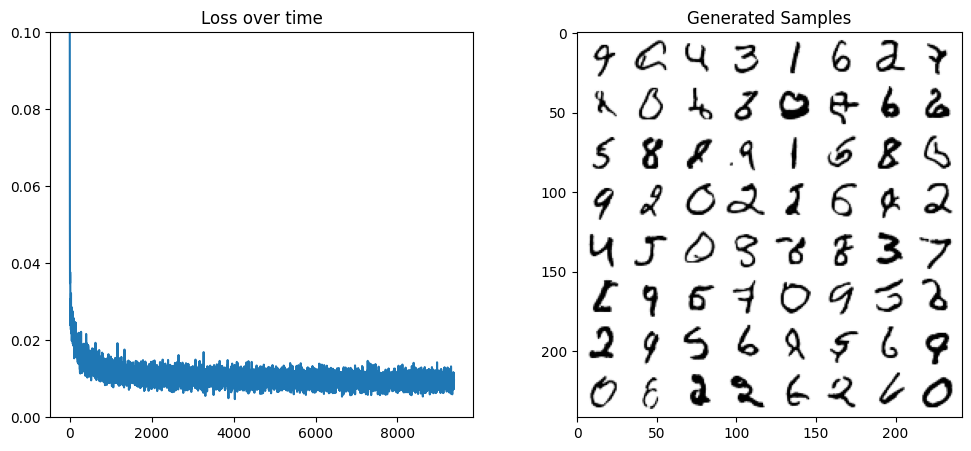

In [19]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_epochs = 20

net = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 64),
    down_block_types=('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'),
    up_block_types=('AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D')
)
net.to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
losses = []

for epoch in range(n_epochs):
    for x, y in train_dataloader:
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)
        
        pred = net(noisy_x, 0).sample
        loss = loss_fn(pred, x)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f"Finished Epoch {epoch}. Average Loss for this epoch: {avg_loss:05f}")
    
    
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0], )).to(device) * (1 - (i / n_steps))
    
    with torch.no_grad():
        pred = net(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
    
axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

## The Corruption Process

In [21]:
??noise_scheduler.add_noise

Object `noise_scheduler.add_noise` not found.


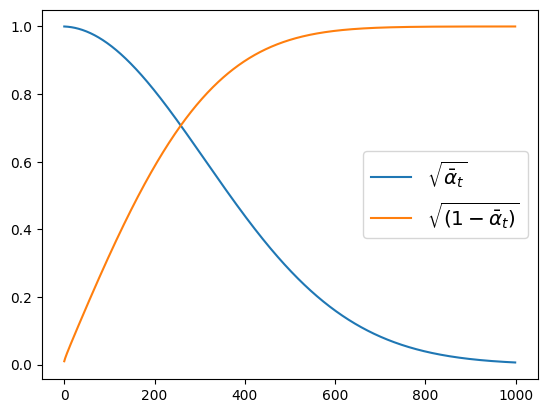

In [22]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


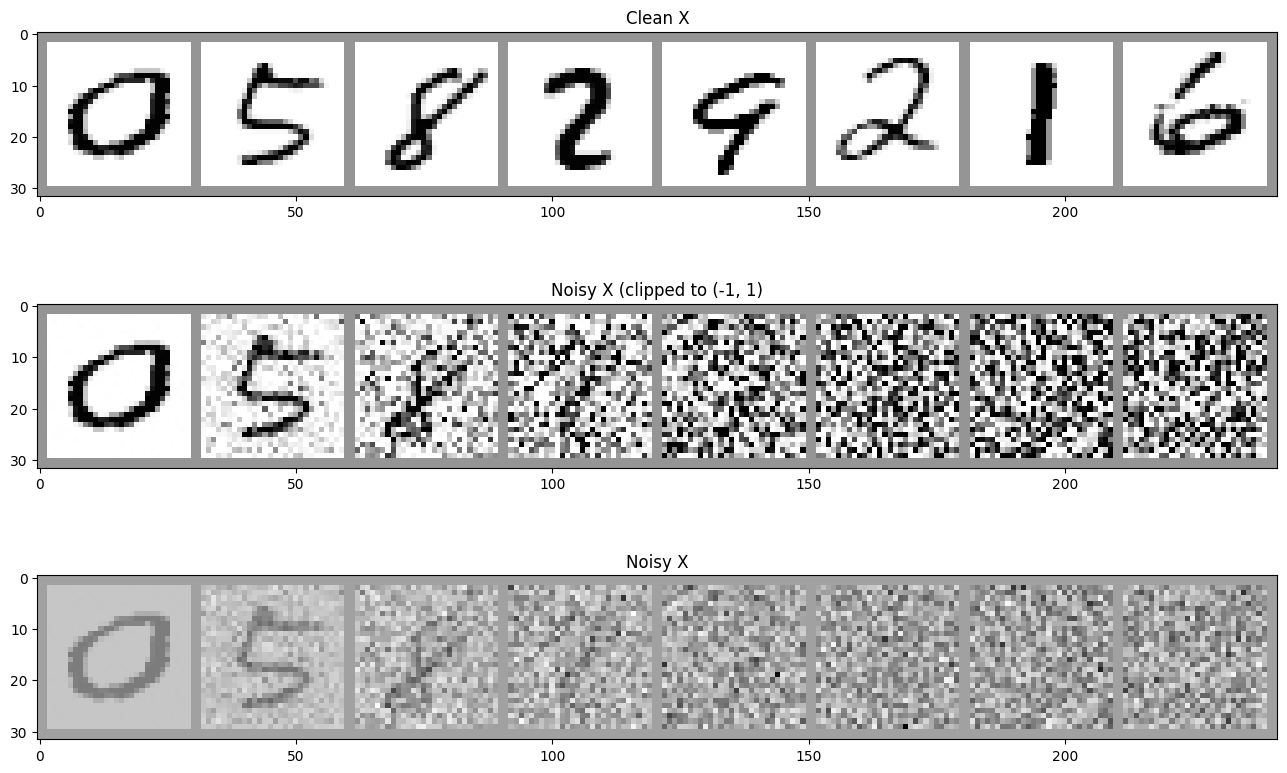

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1.
print('X shape', xb.shape)

axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) 
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');